# Вывод графиков для данных, полученных из KSP

## Библиотеки

### Установка библиотек

In [ ]:
!pip install matplotlib joblib numpy

### Импорт

In [13]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np

## Константы

In [28]:
DATA_PATH = '../data'
TIME_RANGE = 2  # В часах

## Графики

Загрузим объекты

In [32]:
velocities = np.array(joblib.load(os.path.join(DATA_PATH, "velocities.joblib")))
times = np.array(joblib.load(os.path.join(DATA_PATH, "time.joblib")))

Найдем момент T0, и вычтем его из всего времени, переведём время в часы

In [33]:
times -= times[np.argmax(velocities)]
times /= 3600

Найдем все индексы, которые входят во временной диапазон

In [34]:
index_in_time_range = np.argwhere(np.abs(times) <= TIME_RANGE)

Получим график

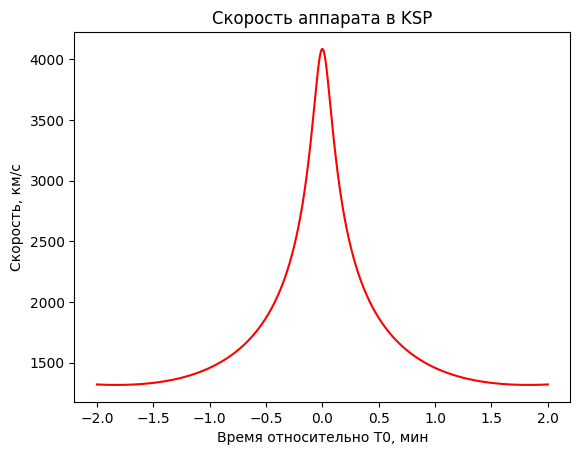

In [37]:
plt.plot(times[index_in_time_range], velocities[index_in_time_range], 'r')
plt.title("Скорость аппарата в KSP")
plt.ylabel("Скорость, км/с")
plt.xlabel("Время относительно T0, мин")
plt.show()